# PM2.5 Air Quality Prediction using LSTM

This notebook demonstrates how to build and train an LSTM (Long Short-Term Memory) neural network to predict PM2.5 air pollution levels using multi-pollutant time series data.

## Project Overview
- **Objective**: Predict PM2.5 concentrations based on historical air quality data
- **Model**: LSTM (Long Short-Term Memory) Neural Network
- **Data**: Multi-pollutant air quality data collected from OpenAQ API
- **Features**: PM2.5, PM10, NO2, SO2, CO, O3

## Notebook Structure
1. Import libraries and load data
2. Exploratory Data Analysis (EDA)
3. Data preprocessing and feature engineering
4. Prepare sequences for LSTM
5. Build and train LSTM model
6. Evaluate model performance
7. Visualize predictions

## 1. Import Required Libraries

Import all necessary libraries for data manipulation, visualization, and machine learning.

In [1]:
# Data manipulation and analysis
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Deep Learning - TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow version: 2.16.2
Keras version: 3.11.3
GPU Available: False


## 2. Load and Explore the Dataset

Load the multi-pollutant air quality data collected from OpenAQ API.

In [2]:
# # Load the multi-pollutant dataset (1 month: Nov 1 - Dec 1, 2025)
# data_path = 'data/raw/openaq_hourly/combined_2025-11-01_2025-12-01.csv'

# # Load the multi-pollutant dataset (6 month: Jun 1 - Dec 1, 2025)
# data_path = 'data/raw/openaq_hourly/combined_2025-06-01_2025-12-01.csv'

# Load the merged pollution + weather dataset (6 month: Jun 1 - Dec 1, 2025)
data_path = 'data/processed/pollution_weather_merged.csv'

df = pd.read_csv(data_path)

# Convert datetime column to datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

# Sort by datetime
df = df.sort_values('datetime').reset_index(drop=True)

print("="*80)
print("DATASET OVERVIEW (Pollution + Weather Data)")
print("="*80)
print(f"\nDataset shape: {df.shape}")
print(f"Date range: {df['datetime'].min()} to {df['datetime'].max()}")
print(f"\nColumns ({len(df.columns)}):")
print("  Pollution: pm25, pm10, no2, so2, co, o3")
print("  Weather: temperature_2m, relative_humidity_2m, dew_point_2m, apparent_temperature,")
print("           precipitation, rain, pressure_msl, surface_pressure, cloud_cover,")
print("           wind_speed_10m, wind_direction_10m, wind_gusts_10m, is_day, sunshine_duration")
print(f"\nData types:\n{df.dtypes}")
print(f"\nFirst few rows:")
df.head()

DATASET OVERVIEW (Pollution + Weather Data)

Dataset shape: (4931, 21)
Date range: 2025-06-01 07:00:00+00:00 to 2025-12-01 23:00:00+00:00

Columns (21):
  Pollution: pm25, pm10, no2, so2, co, o3
  Weather: temperature_2m, relative_humidity_2m, dew_point_2m, apparent_temperature,
           precipitation, rain, pressure_msl, surface_pressure, cloud_cover,
           wind_speed_10m, wind_direction_10m, wind_gusts_10m, is_day, sunshine_duration

Data types:
datetime                datetime64[ns, UTC]
pm25                                float64
pm10                                float64
no2                                 float64
so2                                 float64
co                                  float64
o3                                  float64
temperature_2m                      float64
relative_humidity_2m                  int64
dew_point_2m                        float64
apparent_temperature                float64
precipitation                       float64
rain         

,datetime,pm25,pm10,no2,so2,co,o3,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,pressure_msl,surface_pressure,cloud_cover,wind_speed_10m,wind_direction_10m,wind_gusts_10m,is_day,sunshine_duration
0,2025-06-01 07:00:00+00:00,17.8,17.0,0.0148,0.0001,0.4,0.028,18.2,80,14.6,18.8,0.0,0.0,1013.8,1002.6,99,6.0,207,16.6,0,0.00
1,2025-06-01 08:00:00+00:00,16.2,20.0,0.0152,0.0001,0.3,0.029,17.0,86,14.6,17.1,0.0,0.0,1014.0,1002.7,88,9.7,170,23.4,0,0.00
2,2025-06-01 09:00:00+00:00,15.8,20.0,0.0123,0.0001,0.4,0.030,16.8,87,14.6,17.9,0.0,0.0,1013.6,1002.3,100,2.3,184,22.7,0,0.00
3,2025-06-01 10:00:00+00:00,14.0,18.0,0.0073,0.0001,0.3,0.031,17.1,85,14.5,18.0,0.0,0.0,1012.9,1001.6,100,3.7,259,10.1,0,0.00
4,2025-06-01 11:00:00+00:00,13.5,18.0,0.0088,0.0000,0.3,0.028,17.3,83,14.4,18.0,0.0,0.0,1012.0,1000.8,100,5.2,205,13.0,0,0.00
5,2025-06-01 12:00:00+00:00,11.4,18.0,0.0177,0.0001,0.3,0.019,17.8,81,14.5,18.2,0.0,0.0,1013.5,1002.3,90,7.7,144,20.2,1,0.00
6,2025-06-01 13:00:00+00:00,16.0,19.0,0.0137,0.0002,0.4,0.025,19.2,74,14.4,19.9,0.0,0.0,1013.9,1002.7,86,4.4,63,17.6,1,2355.61
7,2025-06-01 14:00:00+00:00,16.3,25.0,0.0137,0.0004,0.4,0.031,21.2,64,14.1,21.6,0.0,0.0,1014.2,1003.1,50,6.0,139,18.7,1,3600.00
8,2025-06-01 15:00:00+00:00,17.8,30.0,0.0118,0.0004,0.3,0.042,24.4,50,13.4,24.8,0.0,0.0,1014.0,1003.0,100,4.2,137,18.4,1,3600.00
9,2025-06-01 16:00:00+00:00,15.5,25.0,0.0132,0.0003,0.3,0.051,26.9,42,12.9,27.0,0.0,0.0,1013.2,1002.3,99,8.3,162,25.6,1,3600.00


### 2.1 Statistical Summary

In [3]:
# Basic information
print("="*80)
print("BASIC INFORMATION")
print("="*80)
df.info()

# Statistical summary
print("\n" + "="*80)
print("STATISTICAL SUMMARY")
print("="*80)
print(df.describe())

# Check for missing values
print("\n" + "="*80)
print("MISSING VALUES")
print("="*80)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0])

BASIC INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4931 entries, 0 to 4930
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   datetime              4931 non-null   datetime64[ns, UTC]
 1   pm25                  4789 non-null   float64            
 2   pm10                  4893 non-null   float64            
 3   no2                   4809 non-null   float64            
 4   so2                   4805 non-null   float64            
 5   co                    4771 non-null   float64            
 6   o3                    4834 non-null   float64            
 7   temperature_2m        4931 non-null   float64            
 8   relative_humidity_2m  4931 non-null   int64              
 9   dew_point_2m          4931 non-null   float64            
 10  apparent_temperature  4931 non-null   float64            
 11  precipitation         4931 non-null   float64      

### 2.2 Visualize PM2.5 Trends

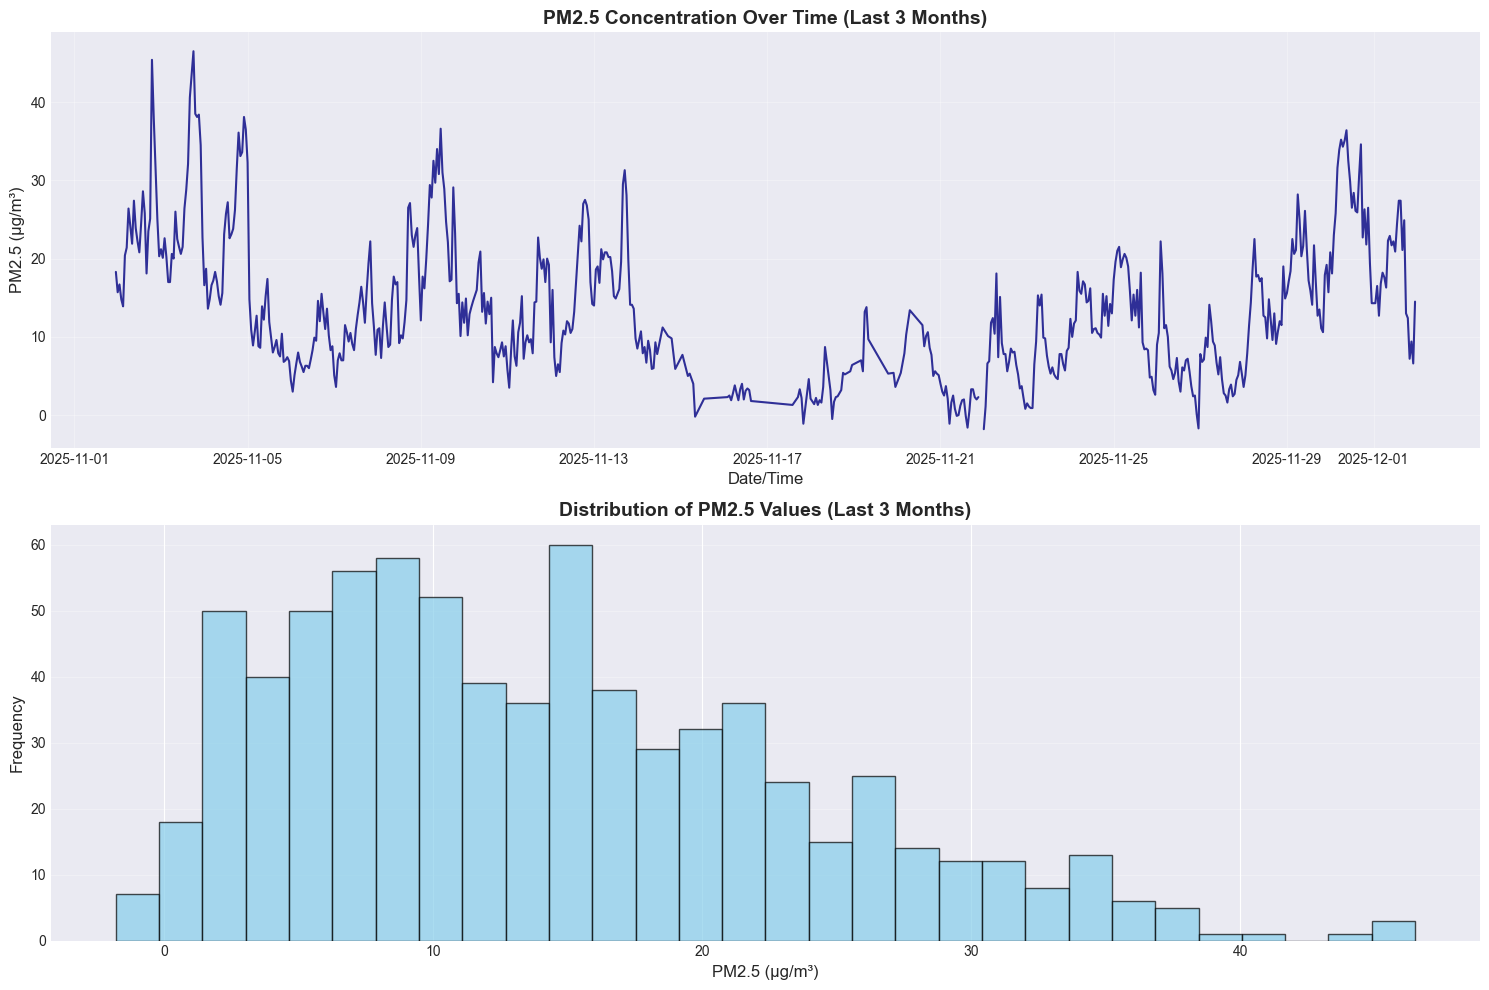

Visualization period: 2025-11-01 23:00:00+00:00 to 2025-12-01 23:00:00+00:00
Number of records shown: 743


In [4]:
# Filter to last 3 months for visualization
last_3_months = df[df['datetime'] >= df['datetime'].max() - pd.Timedelta(days=30)]

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot PM2.5 over time (last 3 months)
axes[0].plot(last_3_months['datetime'], last_3_months['pm25'], color='navy', linewidth=1.5, alpha=0.8)
axes[0].set_xlabel('Date/Time', fontsize=12)
axes[0].set_ylabel('PM2.5 (µg/m³)', fontsize=12)
axes[0].set_title('PM2.5 Concentration Over Time (Last 3 Months)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Distribution of PM2.5 (last 3 months)
axes[1].hist(last_3_months['pm25'].dropna(), bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('PM2.5 (µg/m³)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of PM2.5 Values (Last 3 Months)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Visualization period: {last_3_months['datetime'].min()} to {last_3_months['datetime'].max()}")
print(f"Number of records shown: {len(last_3_months)}")

### 2.3 Correlation Analysis

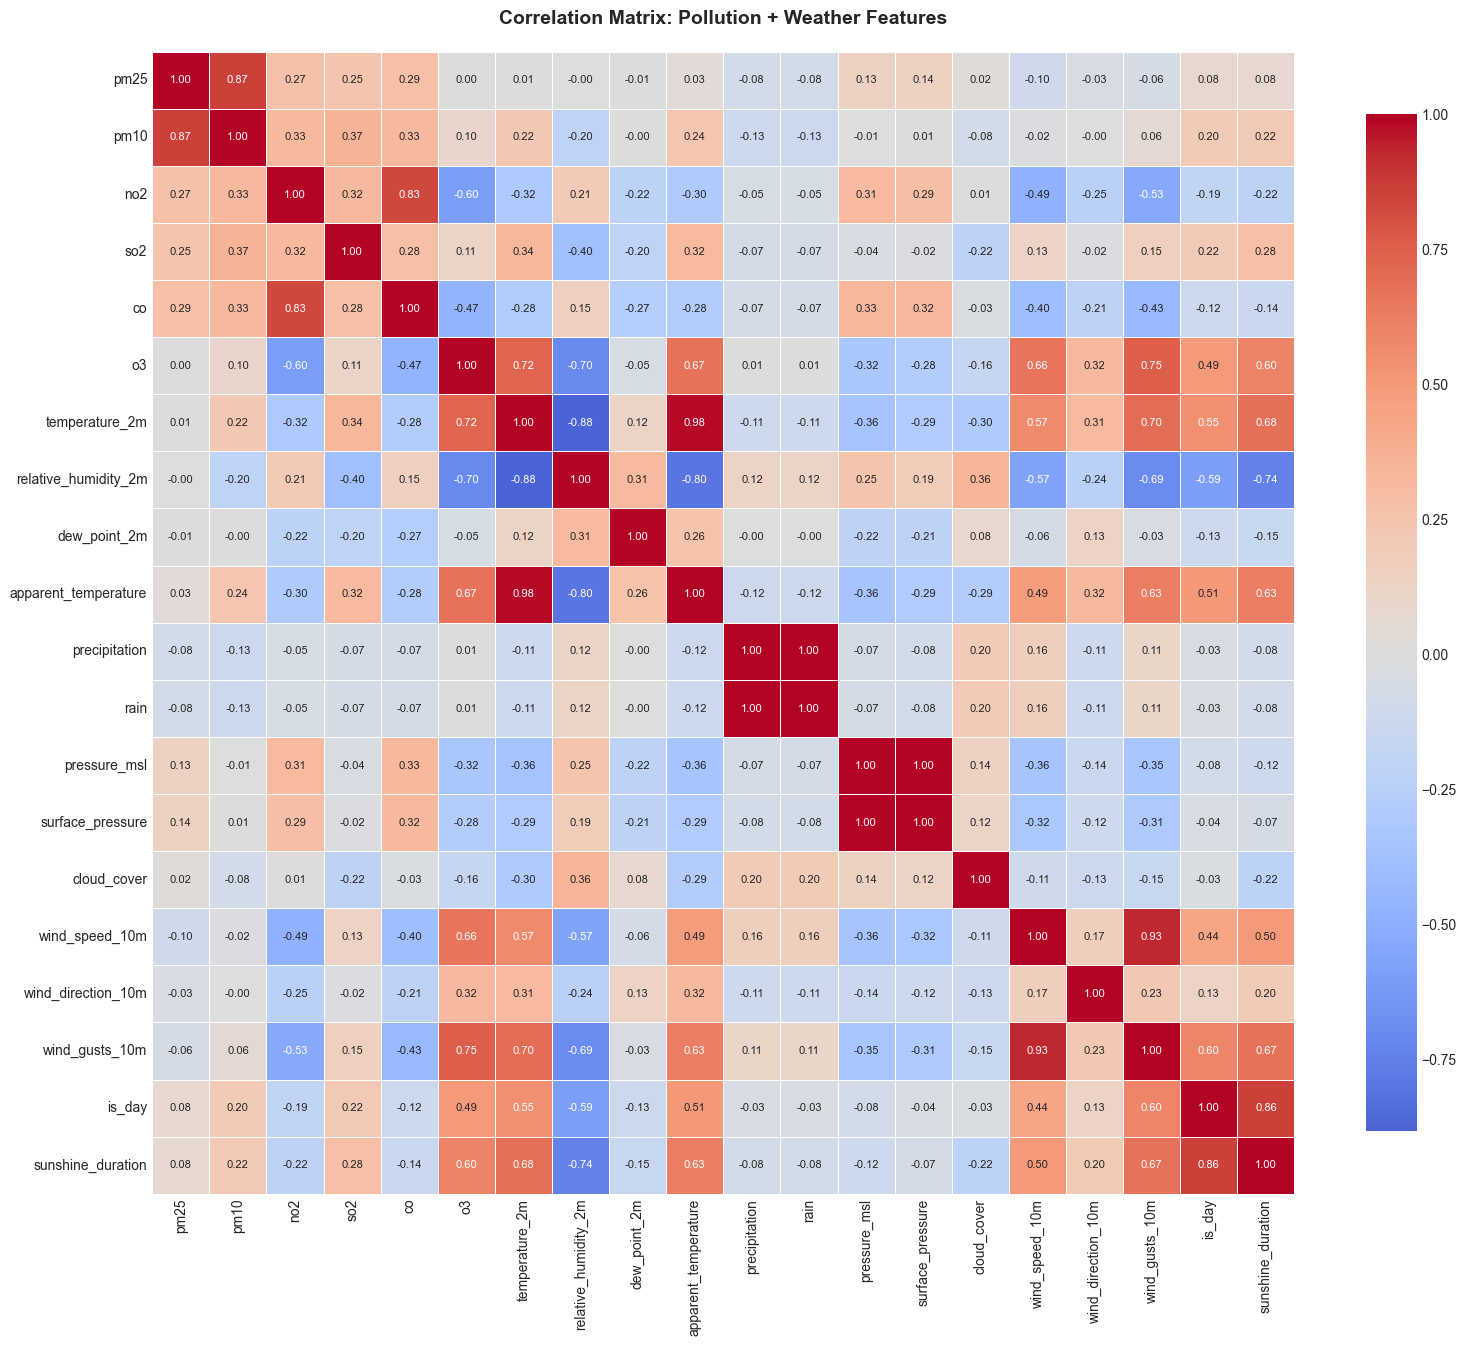

CORRELATION WITH PM2.5 (Target Variable)

Strongest positive correlations:
  pm10: 0.8663
  co: 0.2858
  no2: 0.2713
  so2: 0.2538
  surface_pressure: 0.1375

Strongest negative correlations:
  wind_direction_10m: -0.0345
  wind_gusts_10m: -0.0565
  rain: -0.0814
  precipitation: -0.0814
  wind_speed_10m: -0.1047


In [5]:
# Select numeric columns (excluding datetime)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Calculate correlation matrix
corr_matrix = df[numeric_cols].corr()

# Visualize correlation matrix (larger figure for more features)
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            annot_kws={"size": 8})
plt.title('Correlation Matrix: Pollution + Weather Features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Print correlations with PM2.5
print("="*80)
print("CORRELATION WITH PM2.5 (Target Variable)")
print("="*80)
pm25_corr = corr_matrix['pm25'].drop('pm25').sort_values(ascending=False)
print("\nStrongest positive correlations:")
for col, val in pm25_corr.head(5).items():
    print(f"  {col}: {val:.4f}")
print("\nStrongest negative correlations:")
for col, val in pm25_corr.tail(5).items():
    print(f"  {col}: {val:.4f}")

## 3. Data Preprocessing

### 3.1 Handle Missing Values

In [6]:
# Check for missing values before handling
print("="*80)
print("MISSING VALUES ANALYSIS")
print("="*80)
print("\nMissing values before handling:")
missing_before = df.isnull().sum()
missing_pct_before = (missing_before / len(df)) * 100
for col in df.columns:
    if missing_before[col] > 0:
        print(f"  {col}: {missing_before[col]} ({missing_pct_before[col]:.2f}%)")

# Create a clean copy
df_clean = df.copy()

# Strategy for handling missing values in time series:
# 1. Linear interpolation for small gaps (best for continuous sensor data)
# 2. Forward fill for remaining gaps
# 3. Backward fill for any remaining NaN at the start

# First, set datetime as index for interpolation
df_clean = df_clean.set_index('datetime')

# Apply linear interpolation for numeric columns
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
df_clean[numeric_cols] = df_clean[numeric_cols].interpolate(method='linear', limit_direction='both')

# Fill any remaining NaN with forward/backward fill
df_clean = df_clean.ffill().bfill()

# Reset index
df_clean = df_clean.reset_index()

print("\n" + "="*80)
print("Missing values after handling:")
print(df_clean.isnull().sum().sum(), "total missing values")
print(f"\nDataset shape after cleaning: {df_clean.shape}")
print(f"Date range: {df_clean['datetime'].min()} to {df_clean['datetime'].max()}")

MISSING VALUES ANALYSIS

Missing values before handling:
  pm25: 142 (2.88%)
  pm10: 38 (0.77%)
  no2: 122 (2.47%)
  so2: 126 (2.56%)
  co: 160 (3.24%)
  o3: 97 (1.97%)

Missing values after handling:
0 total missing values

Dataset shape after cleaning: (4931, 21)
Date range: 2025-06-01 07:00:00+00:00 to 2025-12-01 23:00:00+00:00


### 3.2 Feature Engineering - Extract Time Features

In [7]:
# Extract temporal features from datetime
df_clean['hour'] = df_clean['datetime'].dt.hour
df_clean['day_of_week'] = df_clean['datetime'].dt.dayofweek
df_clean['month'] = df_clean['datetime'].dt.month

# Create cyclic features for hour (to capture circular nature of time)
df_clean['hour_sin'] = np.sin(2 * np.pi * df_clean['hour'] / 24)
df_clean['hour_cos'] = np.cos(2 * np.pi * df_clean['hour'] / 24)

print("New features added:")
print(df_clean[['datetime', 'hour', 'day_of_week', 'month', 'hour_sin', 'hour_cos']].head())
print(f"\nUpdated shape: {df_clean.shape}")

New features added:
                   datetime  hour  day_of_week  month  hour_sin  hour_cos
0 2025-06-01 07:00:00+00:00     7            6      6  0.965926 -0.258819
1 2025-06-01 08:00:00+00:00     8            6      6  0.866025 -0.500000
2 2025-06-01 09:00:00+00:00     9            6      6  0.707107 -0.707107
3 2025-06-01 10:00:00+00:00    10            6      6  0.500000 -0.866025
4 2025-06-01 11:00:00+00:00    11            6      6  0.258819 -0.965926

Updated shape: (4931, 26)


### 3.3 Prepare Features and Target

In [8]:
# Define feature columns
# Pollutant features (other air quality indicators)
pollutant_features = ['pm10', 'no2', 'so2', 'co', 'o3']

# Weather features (from Open-Meteo)
weather_features = [
    'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'apparent_temperature',
    'precipitation', 'rain', 'pressure_msl', 'surface_pressure', 'cloud_cover',
    'wind_speed_10m', 'wind_direction_10m', 'wind_gusts_10m', 'is_day', 'sunshine_duration'
]

# Time features (engineered)
time_features = ['hour', 'day_of_week', 'month', 'hour_sin', 'hour_cos']

# Combine all features
feature_cols = pollutant_features + weather_features + time_features

# Target column
target_col = 'pm25'

# Create feature and target arrays
X = df_clean[feature_cols].values
y = df_clean[target_col].values

print("="*80)
print("FEATURE PREPARATION")
print("="*80)
print(f"Feature matrix shape: {X.shape}")
print(f"Target array shape: {y.shape}")
print(f"\nFeature breakdown:")
print(f"  Pollutant features ({len(pollutant_features)}): {pollutant_features}")
print(f"  Weather features ({len(weather_features)}): {weather_features}")
print(f"  Time features ({len(time_features)}): {time_features}")
print(f"\nTotal features: {len(feature_cols)}")
print(f"Target column: {target_col}")

FEATURE PREPARATION
Feature matrix shape: (4931, 24)
Target array shape: (4931,)

Feature breakdown:
  Pollutant features (5): ['pm10', 'no2', 'so2', 'co', 'o3']
  Weather features (14): ['temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'apparent_temperature', 'precipitation', 'rain', 'pressure_msl', 'surface_pressure', 'cloud_cover', 'wind_speed_10m', 'wind_direction_10m', 'wind_gusts_10m', 'is_day', 'sunshine_duration']
  Time features (5): ['hour', 'day_of_week', 'month', 'hour_sin', 'hour_cos']

Total features: 24
Target column: pm25


### 3.4 Scale the Data

In [9]:
# Initialize scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit and transform features and target
X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y.reshape(-1, 1)).flatten()

print("="*80)
print("DATA SCALING")
print("="*80)
print(f"Scaled features shape: {X_scaled.shape}")
print(f"Scaled target shape: {y_scaled.shape}")
print(f"\nFeature range after scaling: [{X_scaled.min():.3f}, {X_scaled.max():.3f}]")
print(f"Target range after scaling: [{y_scaled.min():.3f}, {y_scaled.max():.3f}]")

DATA SCALING
Scaled features shape: (4931, 24)
Scaled target shape: (4931,)

Feature range after scaling: [0.000, 1.000]
Target range after scaling: [0.000, 1.000]


## 4. Create Sequences for LSTM

In [10]:
def create_sequences(X, y, time_steps=24):
    """
    Create sequences for LSTM training.
    
    Args:
        X: Feature array (2D)
        y: Target array (1D)
        time_steps: Number of time steps to look back
    
    Returns:
        X_seq: 3D array (samples, time_steps, features)
        y_seq: 1D array (samples,)
    """
    X_seq, y_seq = [], []
    
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    
    return np.array(X_seq), np.array(y_seq)

# Define time steps (using past 24 hours to predict next hour)
TIME_STEPS = 24

# Create sequences
X_seq, y_seq = create_sequences(X_scaled, y_scaled, TIME_STEPS)

print("="*80)
print("SEQUENCE CREATION FOR LSTM")
print("="*80)
print(f"Time steps (look-back period): {TIME_STEPS} hours")
print(f"Sequence shape: {X_seq.shape}")
print(f"  - Number of samples: {X_seq.shape[0]}")
print(f"  - Time steps per sample: {X_seq.shape[1]}")
print(f"  - Features per time step: {X_seq.shape[2]}")
print(f"Target shape: {y_seq.shape}")

SEQUENCE CREATION FOR LSTM
Time steps (look-back period): 24 hours
Sequence shape: (4907, 24, 24)
  - Number of samples: 4907
  - Time steps per sample: 24
  - Features per time step: 24
Target shape: (4907,)


## 5. Train-Test Split

In [11]:
# Split data: 70% train, 30% test
split_idx = int(0.7 * len(X_seq))

X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

print("="*80)
print("TRAIN-TEST SPLIT")
print("="*80)
print(f"Training set:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"\nTest set:")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")
print(f"\nSplit ratio: {split_idx}/{len(X_seq)} ({split_idx/len(X_seq)*100:.1f}% train)")

TRAIN-TEST SPLIT
Training set:
  X_train shape: (3434, 24, 24)
  y_train shape: (3434,)

Test set:
  X_test shape: (1473, 24, 24)
  y_test shape: (1473,)

Split ratio: 3434/4907 (70.0% train)


## 6. Build LSTM Model

In [12]:
def build_lstm_model(input_shape, units=[64, 32], dropout_rate=0.2):
    """
    Build an LSTM model for time series prediction.
    
    Args:
        input_shape: Tuple (time_steps, features)
        units: List of units for each LSTM layer
        dropout_rate: Dropout rate for regularization
    
    Returns:
        Compiled Keras model
    """
    model = Sequential([
        # First LSTM layer with return sequences
        LSTM(units[0], return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        
        # Second LSTM layer
        LSTM(units[1], return_sequences=False),
        Dropout(dropout_rate),
        
        # Dense layers
        Dense(32, activation='relu'),
        Dropout(dropout_rate),
        
        Dense(1)  # Output layer for regression
    ])
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae', 'mse']
    )
    
    return model

# Build the model
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_lstm_model(input_shape, units=[64, 32], dropout_rate=0.2)

# Display model architecture
print("="*80)
print("LSTM MODEL ARCHITECTURE")
print("="*80)
model.summary()

LSTM MODEL ARCHITECTURE


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        22,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,289 (141.75 KB)

 Trainable params: 36,289 (141.75 KB)

 Non-trainable params: 0 (0.00 B)

## 7. Train the Model

In [13]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Train the model
print("="*80)
print("TRAINING THE MODEL")
print("="*80)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\n" + "="*80)
print("TRAINING COMPLETED")
print("="*80)

TRAINING THE MODEL
Epoch 1/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0049 - mae: 0.0389 - mse: 0.0049 - val_loss: 3.3382e-04 - val_mae: 0.0139 - val_mse: 3.3382e-04 - learning_rate: 0.0010
Epoch 2/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0049 - mae: 0.0389 - mse: 0.0049 - val_loss: 3.3382e-04 - val_mae: 0.0139 - val_mse: 3.3382e-04 - learning_rate: 0.0010
Epoch 2/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0025 - mae: 0.0247 - mse: 0.0025 - val_loss: 3.1906e-04 - val_mae: 0.0136 - val_mse: 3.1906e-04 - learning_rate: 0.0010
Epoch 3/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0025 - mae: 0.0247 - mse: 0.0025 - val_loss: 3.1906e-04 - val_mae: 0.0136 - val_mse: 3.1906e-04 - learning_rate: 0.0010
Epoch 3/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0021 - mae: 0.0224 - mse: 0.0021 - val_loss: 2.9358e-04 - val_mae: 0.0134 - val_mse: 2.9358e-04 - learning_rate: 0.0010
Epoch 4/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss:

### 7.1 Visualize Training History

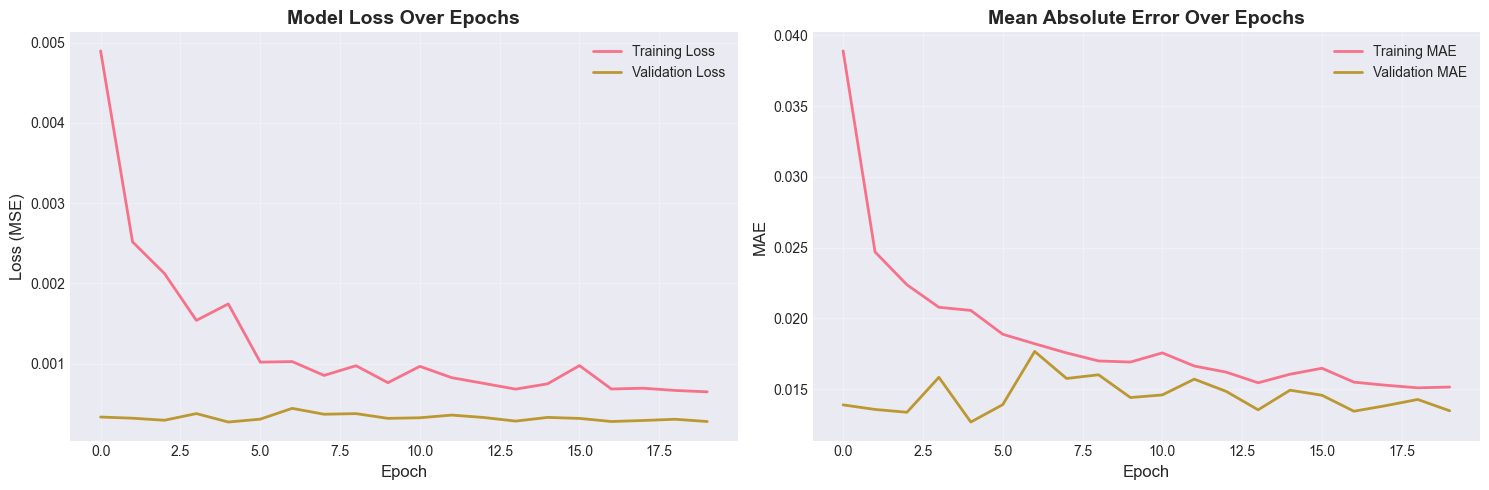

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot MAE
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].set_title('Mean Absolute Error Over Epochs', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Make Predictions

In [15]:
# Make predictions on train and test sets
y_train_pred_scaled = model.predict(X_train, verbose=0).flatten()
y_test_pred_scaled = model.predict(X_test, verbose=0).flatten()

# Inverse transform to get actual values
y_train_pred = target_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_test_pred = target_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

y_train_actual = target_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

print("="*80)
print("PREDICTIONS GENERATED")
print("="*80)
print(f"Training predictions shape: {y_train_pred.shape}")
print(f"Test predictions shape: {y_test_pred.shape}")

PREDICTIONS GENERATED
Training predictions shape: (3434,)
Test predictions shape: (1473,)


## 9. Evaluate Model Performance

In [16]:
# Calculate metrics for training set
train_mae = mean_absolute_error(y_train_actual, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
train_r2 = r2_score(y_train_actual, y_train_pred)

# Calculate metrics for test set
test_mae = mean_absolute_error(y_test_actual, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
test_r2 = r2_score(y_test_actual, y_test_pred)

# Display metrics
print("="*80)
print("MODEL PERFORMANCE METRICS")
print("="*80)
print("\nTraining Set:")
print(f"  MAE:  {train_mae:.4f} µg/m³")
print(f"  RMSE: {train_rmse:.4f} µg/m³")
print(f"  R²:   {train_r2:.4f}")

print("\nTest Set:")
print(f"  MAE:  {test_mae:.4f} µg/m³")
print(f"  RMSE: {test_rmse:.4f} µg/m³")
print(f"  R²:   {test_r2:.4f}")

print("\n" + "="*80)

MODEL PERFORMANCE METRICS

Training Set:
  MAE:  3.8218 µg/m³
  RMSE: 6.5664 µg/m³
  R²:   0.6730

Test Set:
  MAE:  6.4190 µg/m³
  RMSE: 9.1492 µg/m³
  R²:   -0.0678



### 9.1 Visualize Predictions vs Actual Values

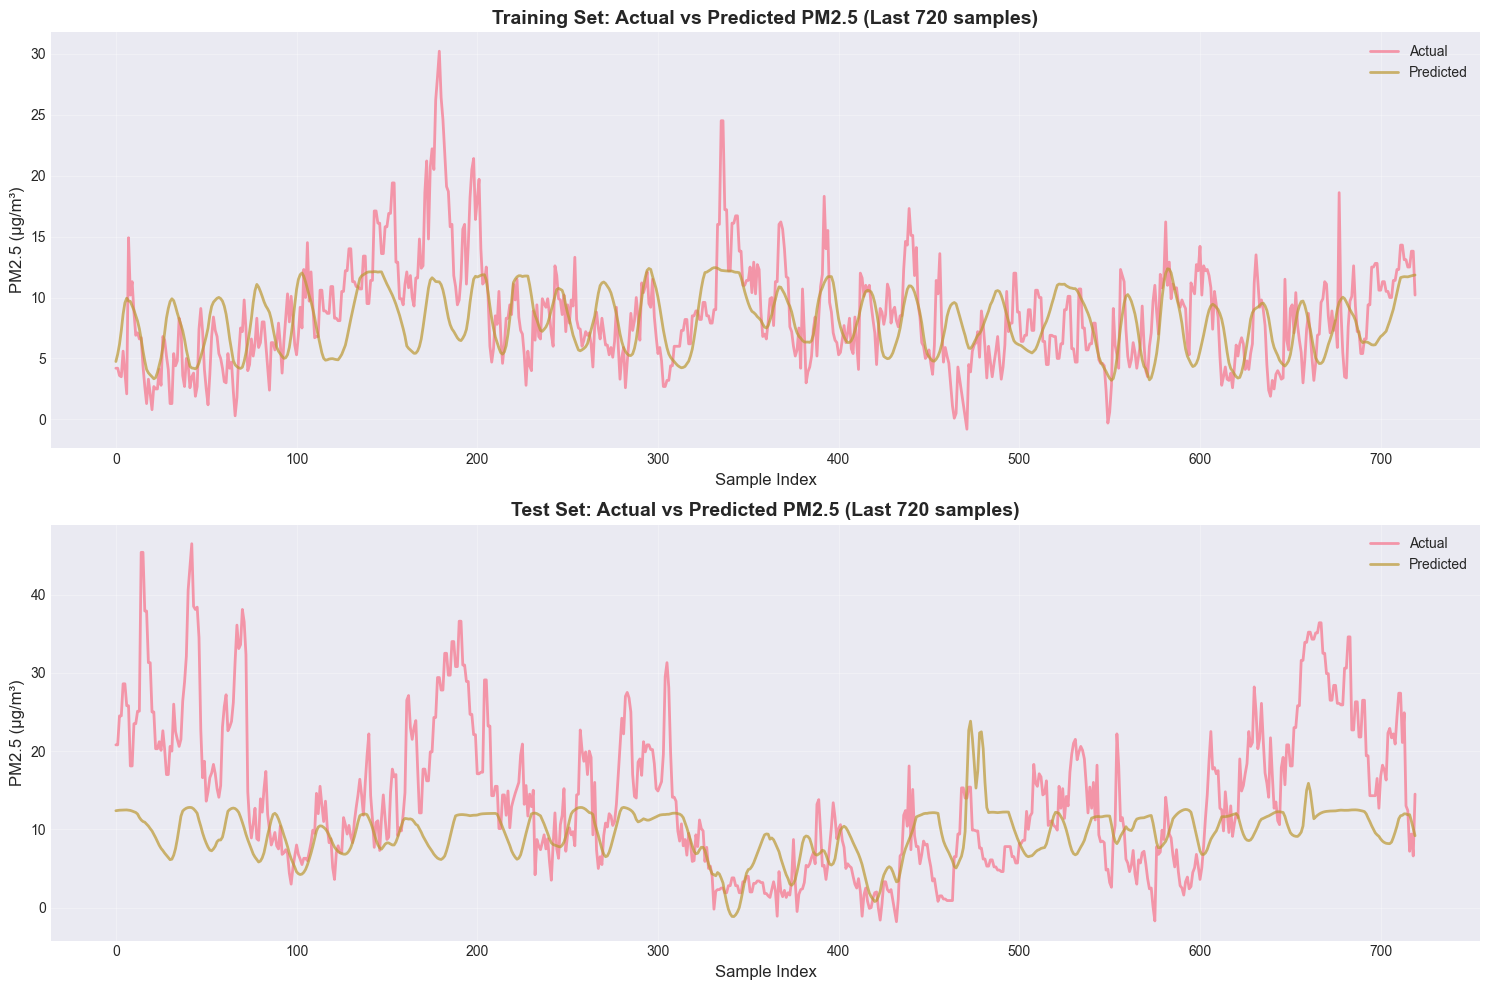

Training on full 6 months, visualizing last ~3 months of each set


In [17]:
# Show only last 3 months of predictions (approximately last ~2160 hours = 90 days)
# Calculate how many samples correspond to ~3 months in test set
samples_3_months = min(len(y_test_actual), 30 * 24)  # 90 days * 24 hours

# For training set, show last portion that corresponds to ~3 months
train_samples_to_show = min(len(y_train_actual), 30 * 24)

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Training set (last 3 months portion)
axes[0].plot(y_train_actual[-train_samples_to_show:], label='Actual', linewidth=2, alpha=0.7)
axes[0].plot(y_train_pred[-train_samples_to_show:], label='Predicted', linewidth=2, alpha=0.7)
axes[0].set_xlabel('Sample Index', fontsize=12)
axes[0].set_ylabel('PM2.5 (µg/m³)', fontsize=12)
axes[0].set_title(f'Training Set: Actual vs Predicted PM2.5 (Last {train_samples_to_show} samples)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test set (last 3 months or all if less)
axes[1].plot(y_test_actual[-samples_3_months:], label='Actual', linewidth=2, alpha=0.7)
axes[1].plot(y_test_pred[-samples_3_months:], label='Predicted', linewidth=2, alpha=0.7)
axes[1].set_xlabel('Sample Index', fontsize=12)
axes[1].set_ylabel('PM2.5 (µg/m³)', fontsize=12)
axes[1].set_title(f'Test Set: Actual vs Predicted PM2.5 (Last {samples_3_months} samples)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Training on full 6 months, visualizing last ~3 months of each set")

## 10. Next Day PM2.5 Prediction

Use the trained model to predict PM2.5 levels for the next 24 hours based on the most recent data.

In [18]:
# Get the most recent 24 hours of data for prediction
last_sequence = X_scaled[-TIME_STEPS:].reshape(1, TIME_STEPS, -1)

# Predict next 24 hours iteratively
next_day_predictions = []
current_sequence = last_sequence.copy()

print("="*80)
print("NEXT 24-HOUR PM2.5 PREDICTION")
print("="*80)

for hour in range(24):
    # Predict next hour
    next_pred_scaled = model.predict(current_sequence, verbose=0)[0, 0]
    
    # Inverse transform to get actual PM2.5 value
    next_pred_actual = target_scaler.inverse_transform([[next_pred_scaled]])[0, 0]
    next_day_predictions.append(next_pred_actual)
    
    # Update sequence for next prediction (shift and add new prediction)
    # For simplicity, we'll use the predicted PM2.5 and keep other features constant
    new_features = current_sequence[0, -1, :].copy()  # Copy last time step features
    
    # Update the sequence: remove first time step, add new one at the end
    current_sequence = np.roll(current_sequence, -1, axis=1)
    current_sequence[0, -1, :] = new_features

# Create prediction dataframe
last_datetime = df_clean['datetime'].iloc[-1]
prediction_times = [last_datetime + timedelta(hours=i+1) for i in range(24)]

next_day_df = pd.DataFrame({
    'datetime': prediction_times,
    'predicted_pm25': next_day_predictions
})

print(f"\nPrediction starting from: {last_datetime}")
print(f"Predicting for: {prediction_times[0]} to {prediction_times[-1]}")
print(f"\nNext 24-Hour Predictions:")
print(next_day_df.to_string(index=False))

NEXT 24-HOUR PM2.5 PREDICTION

Prediction starting from: 2025-12-01 23:00:00+00:00
Predicting for: 2025-12-02 00:00:00+00:00 to 2025-12-02 23:00:00+00:00

Next 24-Hour Predictions:
                 datetime  predicted_pm25
2025-12-02 00:00:00+00:00        8.264964
2025-12-02 01:00:00+00:00        7.553671
2025-12-02 02:00:00+00:00        7.052374
2025-12-02 03:00:00+00:00        6.696790
2025-12-02 04:00:00+00:00        6.447895
2025-12-02 05:00:00+00:00        6.270115
2025-12-02 06:00:00+00:00        6.131008
2025-12-02 07:00:00+00:00        6.032837
2025-12-02 08:00:00+00:00        5.957802
2025-12-02 09:00:00+00:00        5.902657
2025-12-02 10:00:00+00:00        5.856011
2025-12-02 11:00:00+00:00        5.817227
2025-12-02 12:00:00+00:00        5.792455
2025-12-02 13:00:00+00:00        5.769996
2025-12-02 14:00:00+00:00        5.748639
2025-12-02 15:00:00+00:00        5.734014
2025-12-02 16:00:00+00:00        5.700172
2025-12-02 17:00:00+00:00        5.677512
2025-12-02 18:00:00+0

### 10.1 Visualize Next Day Prediction

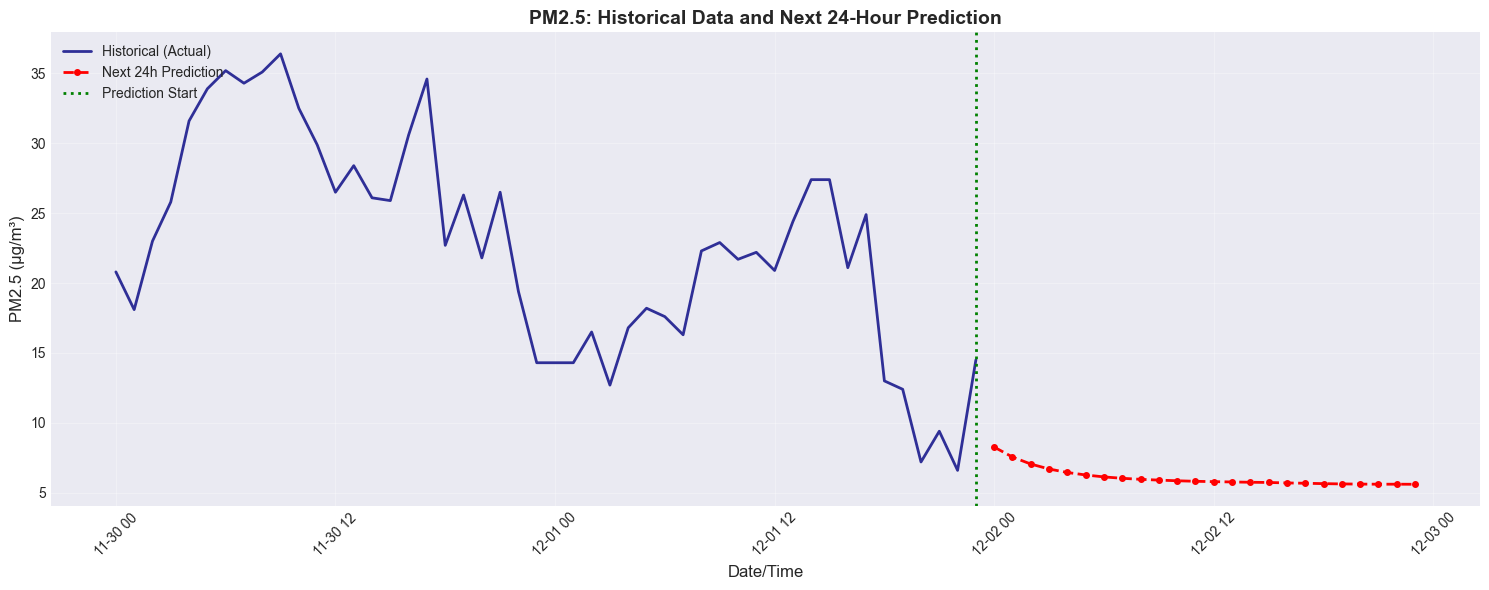

NEXT DAY PREDICTION SUMMARY

Predicted PM2.5 Statistics:
  Min:  5.60 µg/m³
  Max:  8.26 µg/m³
  Mean: 6.09 µg/m³
  Std:  0.68 µg/m³

Expected Air Quality: Good


In [19]:
# Visualize the next day prediction along with recent historical data
fig, ax = plt.subplots(figsize=(15, 6))

# Plot last 72 hours of actual data (3 days)
recent_hours = 72
recent_data = df_clean.tail(recent_hours)

ax.plot(recent_data['datetime'], recent_data['pm25'], 
        label='Historical (Actual)', color='navy', linewidth=2, alpha=0.8)

# Plot the prediction
ax.plot(next_day_df['datetime'], next_day_df['predicted_pm25'], 
        label='Next 24h Prediction', color='red', linewidth=2, linestyle='--', marker='o', markersize=4)

# Add vertical line to separate historical and predicted
ax.axvline(x=last_datetime, color='green', linestyle=':', linewidth=2, label='Prediction Start')

# Formatting
ax.set_xlabel('Date/Time', fontsize=12)
ax.set_ylabel('PM2.5 (µg/m³)', fontsize=12)
ax.set_title('PM2.5: Historical Data and Next 24-Hour Prediction', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Summary statistics
print("="*80)
print("NEXT DAY PREDICTION SUMMARY")
print("="*80)
print(f"\nPredicted PM2.5 Statistics:")
print(f"  Min:  {next_day_df['predicted_pm25'].min():.2f} µg/m³")
print(f"  Max:  {next_day_df['predicted_pm25'].max():.2f} µg/m³")
print(f"  Mean: {next_day_df['predicted_pm25'].mean():.2f} µg/m³")
print(f"  Std:  {next_day_df['predicted_pm25'].std():.2f} µg/m³")

# Air quality index interpretation
avg_pm25 = next_day_df['predicted_pm25'].mean()
if avg_pm25 <= 12:
    air_quality = "Good"
elif avg_pm25 <= 35.4:
    air_quality = "Moderate"
elif avg_pm25 <= 55.4:
    air_quality = "Unhealthy for Sensitive Groups"
elif avg_pm25 <= 150.4:
    air_quality = "Unhealthy"
elif avg_pm25 <= 250.4:
    air_quality = "Very Unhealthy"
else:
    air_quality = "Hazardous"

print(f"\nExpected Air Quality: {air_quality}")